In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchaudio.transforms as T
from torchvision.models import resnet18
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')

In [4]:
data_dir = '//kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [5]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [6]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 1
train_size = 0.8

In [7]:
recordings_old = sorted(os.listdir(data_dir))

In [8]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [9]:
len(recordings)

638

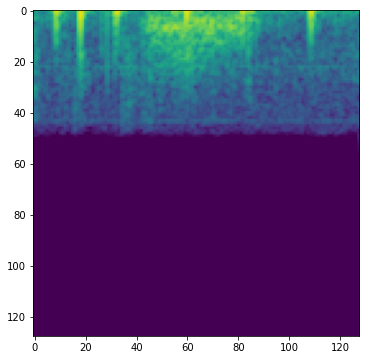

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [11]:
image_size = melspec.shape
image_size

(128, 128)

In [12]:
melspec = torch.tensor(melspec)
melspec = torch.stack([melspec, melspec, melspec])

In [13]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 12):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 12):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(12)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 12)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [14]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [15]:
class HeartbeatSounds(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
data = []
labels = []
for i in range(len(recordings)):
    if 'normal' in recordings[i]:
        label = 0
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'extrastole' in recordings[i]:
        label = 1
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'murmur' in recordings[i]:
        label = 2
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)

In [17]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [18]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [19]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No Augmentation

In [20]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = False, aug_type = 'No', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0
Train
0.7603251153367961
TEST
loss: 0.5544550967594933
accuracy: 0.8158730158730159
******************
epoch: 1
Train
0.5555719979421027
TEST
loss: 0.49233690708402605
accuracy: 0.8222222222222222
******************
epoch: 2
Train
0.4679527095947311
TEST
loss: 0.5784339200882684
accuracy: 0.8063492063492064
******************
epoch: 3
Train
0.4029487905827091
TEST
loss: 0.6924342405228388
accuracy: 0.8031746031746032
******************
epoch: 4
Train
0.42157044076465067
TEST
loss: 0.6061104119770111
accuracy: 0.8253968253968254
******************
epoch: 5
Train
0.40403444161956703
TEST
loss: 1.1397882105812194
accuracy: 0.765079365079365
******************
epoch: 6
Train
0.3435787437357914
TEST
loss: 1.2518886721323408
accuracy: 0.25396825396825395
******************
epoch: 7
Train
0.25107719707195486
TEST
loss: 0.7093003817967006
accuracy: 0.8380952380952381
******************
epoch: 8
Train
0.24052752671590202
TEST
loss: 0.9525810521746438
accuracy: 0.6825396825396826
******

In [21]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8147208121827412


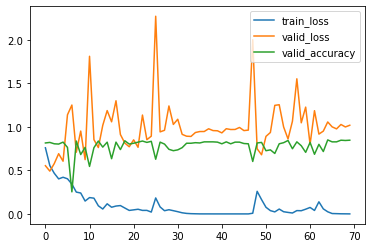

In [22]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [23]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.837163429656987
TEST
loss: 0.6398270760263716
accuracy: 0.8031746031746032
******************
epoch: 1
Train
0.5856434982196029
TEST
loss: 0.7572880279450189
accuracy: 0.7555555555555555
******************
epoch: 2
Train
0.5308224994621171
TEST
loss: 1.0069046463285174
accuracy: 0.580952380952381
******************
epoch: 3
Train
0.4820959243251749
TEST
loss: 0.5609071748597282
accuracy: 0.8412698412698413
******************
epoch: 4
Train
0.5173825274581848
TEST
loss: 0.961233765738351
accuracy: 0.692063492063492
******************
epoch: 5
Train
0.4277592852202742
TEST
loss: 0.47140600321784853
accuracy: 0.8253968253968254
******************
epoch: 6
Train
0.4109093166941021
TEST
loss: 0.6930218757144988
accuracy: 0.7174603174603175
******************
epoch: 7
Train
0.356542644470433
TEST
loss: 0.549453372047061
accuracy: 0.7492063492063492
******************
epoch: 8
Train
0.337408819730742
TEST
loss: 0.6404927094777425
accuracy: 0.83809

In [24]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8020304568527918


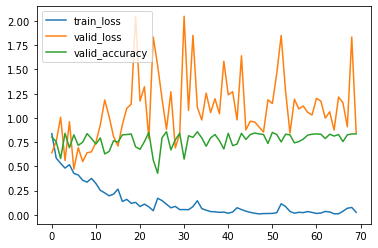

In [25]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [26]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8268353852892414
TEST
loss: 0.6422729539492774
accuracy: 0.7777777777777778
******************
epoch: 1
Train
0.5825774027204779
TEST
loss: 0.5899542027049595
accuracy: 0.8317460317460318
******************
epoch: 2
Train
0.5035549562610834
TEST
loss: 0.6339425480554974
accuracy: 0.7968253968253968
******************
epoch: 3
Train
0.4585284170790075
TEST
loss: 0.5806585489757478
accuracy: 0.7904761904761904
******************
epoch: 4
Train
0.46087011628628155
TEST
loss: 0.7519387790134975
accuracy: 0.7174603174603175
******************
epoch: 5
Train
0.4108385520146137
TEST
loss: 0.4773981179509844
accuracy: 0.8253968253968254
******************
epoch: 6
Train
0.3460653686424017
TEST
loss: 0.6190339332535153
accuracy: 0.8
******************
epoch: 7
Train
0.31497264725050345
TEST
loss: 0.5683472551996746
accuracy: 0.7873015873015873
******************
epoch: 8
Train
0.27634318314960216
TEST
loss: 0.6251650972971841
accuracy: 0.82857142857

In [27]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8274111675126904


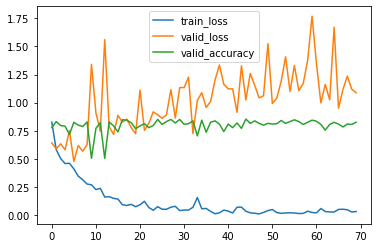

In [28]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [29]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.7883803544061538
TEST
loss: 0.5890883729571388
accuracy: 0.8031746031746032
******************
epoch: 1
Train
0.509482951439781
TEST
loss: 0.8556162837951903
accuracy: 0.726984126984127
******************
epoch: 2
Train
0.492273519397066
TEST
loss: 0.44811628621722027
accuracy: 0.8444444444444444
******************
epoch: 3
Train
0.400620082643318
TEST
loss: 0.5230852509301807
accuracy: 0.8126984126984127
******************
epoch: 4
Train
0.3635474682753762
TEST
loss: 0.9365098237991333
accuracy: 0.6730158730158731
******************
epoch: 5
Train
0.3375400059321648
TEST
loss: 0.7998695867402213
accuracy: 0.726984126984127
******************
epoch: 6
Train
0.28274841797171935
TEST
loss: 1.3013522969351874
accuracy: 0.6698412698412698
******************
epoch: 7
Train
0.25839506295036946
TEST
loss: 0.8361059991140214
accuracy: 0.7047619047619048
******************
epoch: 8
Train
0.17874384821171416
TEST
loss: 0.6987657431572203
accuracy: 0.

In [30]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8451776649746193


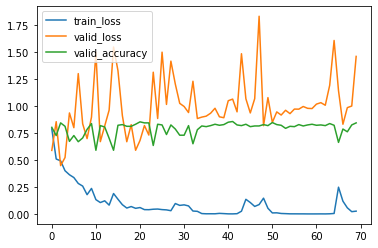

In [31]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [32]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.7739206164057431
TEST
loss: 0.7155564627950154
accuracy: 0.780952380952381
******************
epoch: 1
Train
0.5545308075318552
TEST
loss: 0.5902769347978016
accuracy: 0.8158730158730159
******************
epoch: 2
Train
0.46291943837765004
TEST
loss: 0.502152322965955
accuracy: 0.8539682539682539
******************
epoch: 3
Train
0.42710486208284726
TEST
loss: 1.1253818402214655
accuracy: 0.7111111111111111
******************
epoch: 4
Train
0.4456711006221362
TEST
loss: 0.6326729352512057
accuracy: 0.780952380952381
******************
epoch: 5
Train
0.39040783305694604
TEST
loss: 0.6157189571668231
accuracy: 0.7968253968253968
******************
epoch: 6
Train
0.3152472743257064
TEST
loss: 0.7974213357955691
accuracy: 0.7746031746031746
******************
epoch: 7
Train
0.24054269115066984
TEST
loss: 0.7390376885732015
accuracy: 0.8222222222222222
******************
epoch: 8
Train
0.24111307784619077
TEST
loss: 0.7784530325541421
accuracy:

In [33]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.817258883248731


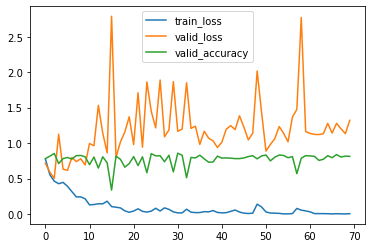

In [34]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [35]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.86978088450678
TEST
loss: 0.849298065806192
accuracy: 0.7904761904761904
******************
epoch: 1
Train
0.6528064525723931
TEST
loss: 0.637470411308228
accuracy: 0.8063492063492064
******************
epoch: 2
Train
0.5656809196337714
TEST
loss: 0.5289355217464387
accuracy: 0.834920634920635
******************
epoch: 3
Train
0.5236824256404228
TEST
loss: 0.5696758775483994
accuracy: 0.8095238095238095
******************
epoch: 4
Train
0.5597095764563896
TEST
loss: 0.631399839265006
accuracy: 0.7587301587301587
******************
epoch: 5
Train
0.525469645159504
TEST
loss: 0.7009168178316146
accuracy: 0.7714285714285715
******************
epoch: 6
Train
0.5212948662454501
TEST
loss: 0.5401853264324249
accuracy: 0.8380952380952381
******************
epoch: 7
Train
0.4592584205866807
TEST
loss: 1.1917684668586368
accuracy: 0.5650793650793651
******************
epoch: 8
Train
0.5368583520861065
TEST
loss: 0.6579793844904218
accuracy: 0.831746

In [36]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8604060913705583


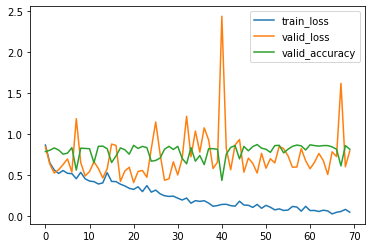

In [37]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [38]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.001110528484046
TEST
loss: 0.6016055059811426
accuracy: 0.7841269841269841
******************
epoch: 1
Train
0.7084196360457786
TEST
loss: 0.586041385976095
accuracy: 0.8
******************
epoch: 2
Train
0.6932844644126862
TEST
loss: 0.5885775655034988
accuracy: 0.8222222222222222
******************
epoch: 3
Train
0.673856600113006
TEST
loss: 0.5453265771033272
accuracy: 0.8285714285714286
******************
epoch: 4
Train
0.6581456432084984
TEST
loss: 0.7538448212638734
accuracy: 0.7777777777777778
******************
epoch: 5
Train
0.6572978639053484
TEST
loss: 0.5982270006149534
accuracy: 0.7428571428571429
******************
epoch: 6
Train
0.672285957076987
TEST
loss: 0.5287255485852559
accuracy: 0.819047619047619
******************
epoch: 7
Train
0.610701418992922
TEST
loss: 0.5676559200362553
accuracy: 0.8158730158730159
******************
epoch: 8
Train
0.596304968176994
TEST
loss: 0.5256748114313398
accuracy: 0.8317460317460318
****

In [39]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8020304568527918


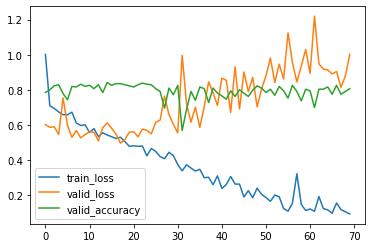

In [40]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [41]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8986921872147688
TEST
loss: 0.9147802368042961
accuracy: 0.7015873015873015
******************
epoch: 1
Train
0.6902225368831535
TEST
loss: 0.8104439145042783
accuracy: 0.6761904761904762
******************
epoch: 2
Train
0.6685077335931082
TEST
loss: 0.6282248385368832
accuracy: 0.7619047619047619
******************
epoch: 3
Train
0.5795308138000482
TEST
loss: 0.9471964836120605
accuracy: 0.819047619047619
******************
epoch: 4
Train
0.5996398252092533
TEST
loss: 1.1704881248019992
accuracy: 0.7015873015873015
******************
epoch: 5
Train
0.5402762167883639
TEST
loss: 0.6435612720156473
accuracy: 0.7492063492063492
******************
epoch: 6
Train
0.5335150822890572
TEST
loss: 0.9230422464628069
accuracy: 0.5301587301587302
******************
epoch: 7
Train
0.4862875806802412
TEST
loss: 0.5408744096755982
accuracy: 0.819047619047619
******************
epoch: 8
Train
0.46509268939069
TEST
loss: 1.0820586624599637
accuracy: 0.406

In [42]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8121827411167513


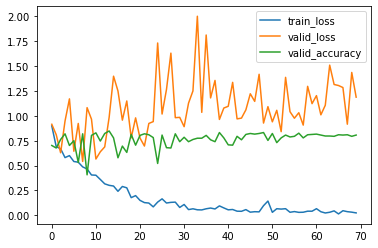

In [43]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [44]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8213944116502266
TEST
loss: 0.6582362447466169
accuracy: 0.7714285714285715
******************
epoch: 1
Train
0.565434394799309
TEST
loss: 0.5836182840286739
accuracy: 0.8031746031746032
******************
epoch: 2
Train
0.5243162966797141
TEST
loss: 0.6629624924962483
accuracy: 0.8
******************
epoch: 3
Train
0.4877506481739526
TEST
loss: 0.5761997637294588
accuracy: 0.7111111111111111
******************
epoch: 4
Train
0.3792151500891844
TEST
loss: 0.5082807815264142
accuracy: 0.8158730158730159
******************
epoch: 5
Train
0.3537707254941545
TEST
loss: 0.56918813576774
accuracy: 0.8158730158730159
******************
epoch: 6
Train
0.3191923882110996
TEST
loss: 1.058191628683181
accuracy: 0.546031746031746
******************
epoch: 7
Train
0.3086646866760527
TEST
loss: 0.8145019786698477
accuracy: 0.6031746031746031
******************
epoch: 8
Train
0.20283476188127914
TEST
loss: 1.1397246761927529
accuracy: 0.8285714285714286
*

In [45]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.817258883248731


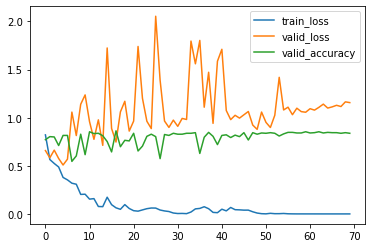

In [46]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [47]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.7926927214108165
TEST
loss: 0.6701606559374976
accuracy: 0.7714285714285715
******************
epoch: 1
Train
0.5524373538348294
TEST
loss: 0.5715431896467057
accuracy: 0.8063492063492064
******************
epoch: 2
Train
0.5083070426256151
TEST
loss: 0.5646452602886018
accuracy: 0.7936507936507936
******************
epoch: 3
Train
0.4283194482515879
TEST
loss: 0.784773153728909
accuracy: 0.6793650793650794
******************
epoch: 4
Train
0.3531040692963801
TEST
loss: 0.9984868227489411
accuracy: 0.6444444444444445
******************
epoch: 5
Train
0.34268431274354977
TEST
loss: 0.659317640085069
accuracy: 0.8158730158730159
******************
epoch: 6
Train
0.3102249970409584
TEST
loss: 0.6394719629060654
accuracy: 0.7682539682539683
******************
epoch: 7
Train
0.27748600375188354
TEST
loss: 0.6331673368575081
accuracy: 0.7873015873015873
******************
epoch: 8
Train
0.22018622621787362
TEST
loss: 0.7150871127370804
accuracy: 

In [48]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8121827411167513


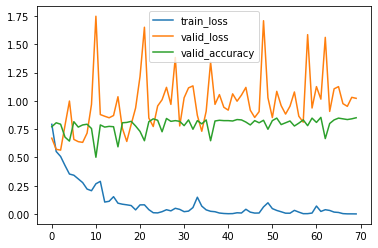

In [49]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [50]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.7687817327175186
TEST
loss: 0.5965082236698696
accuracy: 0.8063492063492064
******************
epoch: 1
Train
0.6244714618013244
TEST
loss: 0.5419966434675549
accuracy: 0.8063492063492064
******************
epoch: 2
Train
0.5387100702812977
TEST
loss: 0.43377523365474885
accuracy: 0.8444444444444444
******************
epoch: 3
Train
0.5276961520941509
TEST
loss: 0.7711202765267993
accuracy: 0.8095238095238095
******************
epoch: 4
Train
0.5405906955811407
TEST
loss: 0.5629403362198482
accuracy: 0.8
******************
epoch: 5
Train
0.5016411534370744
TEST
loss: 0.7079949265434629
accuracy: 0.7619047619047619
******************
epoch: 6
Train
0.4857680900074169
TEST
loss: 0.5446794549624125
accuracy: 0.8317460317460318
******************
epoch: 7
Train
0.40443925011527265
TEST
loss: 0.5892863560290563
accuracy: 0.7904761904761904
******************
epoch: 8
Train
0.42560731901878207
TEST
loss: 0.7011965475385151
accuracy: 0.75873015873

In [51]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8807106598984772


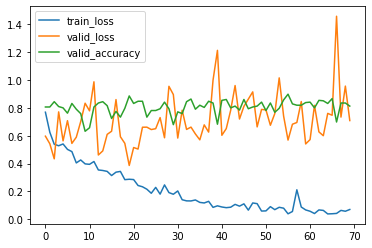

In [52]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [53]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.9570443780532046
TEST
loss: 0.69694967534807
accuracy: 0.7492063492063492
******************
epoch: 1
Train
0.7166934064970403
TEST
loss: 0.5681025166360159
accuracy: 0.8158730158730159
******************
epoch: 2
Train
0.6676016334885164
TEST
loss: 0.5737982568286714
accuracy: 0.8126984126984127
******************
epoch: 3
Train
0.6675048200879616
TEST
loss: 0.5815474025786869
accuracy: 0.8063492063492064
******************
epoch: 4
Train
0.6542761559473134
TEST
loss: 0.6028159771646772
accuracy: 0.8
******************
epoch: 5
Train
0.6479131365882868
TEST
loss: 0.7540906215470935
accuracy: 0.6507936507936508
******************
epoch: 6
Train
0.6628334054263268
TEST
loss: 0.5147176827703204
accuracy: 0.8317460317460318
******************
epoch: 7
Train
0.5616657748593519
TEST
loss: 0.8216224424422733
accuracy: 0.7333333333333333
******************
epoch: 8
Train
0.5713411671619173
TEST
loss: 0.4913166091555641
accuracy: 0.8285714285714286

In [54]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.817258883248731


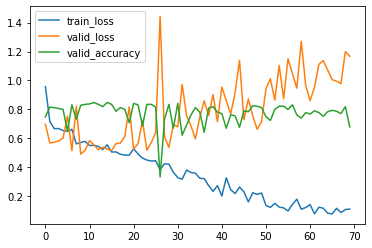

In [55]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [56]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.7783105338703933
TEST
loss: 0.597247338484204
accuracy: 0.8063492063492064
******************
epoch: 1
Train
0.641694895372777
TEST
loss: 0.5809765022898478
accuracy: 0.8031746031746032
******************
epoch: 2
Train
0.5541685380284231
TEST
loss: 0.6131952204401531
accuracy: 0.7936507936507936
******************
epoch: 3
Train
0.5064293784788433
TEST
loss: 0.6969780049626789
accuracy: 0.746031746031746
******************
epoch: 4
Train
0.591079072690938
TEST
loss: 0.6477237156459263
accuracy: 0.7936507936507936
******************
epoch: 5
Train
0.532079578179798
TEST
loss: 0.5312599518942455
accuracy: 0.8317460317460318
******************
epoch: 6
Train
0.51595105118369
TEST
loss: 1.6106935879540822
accuracy: 0.4507936507936508
******************
epoch: 7
Train
0.4389946496704441
TEST
loss: 0.4572736373023381
accuracy: 0.8412698412698413
******************
epoch: 8
Train
0.4544050116402654
TEST
loss: 0.6120144283960736
accuracy: 0.803174

In [57]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8705583756345178


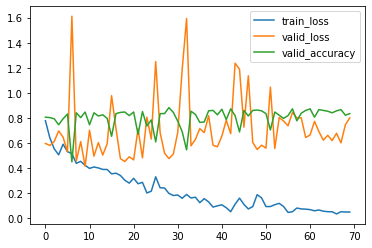

In [58]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [59]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.9552613271901871
TEST
loss: 0.7023026926176889
accuracy: 0.7682539682539683
******************
epoch: 1
Train
0.7192847273291056
TEST
loss: 0.5642999667969961
accuracy: 0.8158730158730159
******************
epoch: 2
Train
0.6333181977840148
TEST
loss: 0.6038953972241236
accuracy: 0.7555555555555555
******************
epoch: 3
Train
0.6194818908018759
TEST
loss: 0.7723161023760599
accuracy: 0.7111111111111111
******************
epoch: 4
Train
0.6308786588779416
TEST
loss: 0.6320807131509932
accuracy: 0.7904761904761904
******************
epoch: 5
Train
0.6179280312786603
TEST
loss: 1.268293733445425
accuracy: 0.24126984126984127
******************
epoch: 6
Train
0.5902144608988091
TEST
loss: 0.462781994872623
accuracy: 0.8285714285714286
******************
epoch: 7
Train
0.5474903685787161
TEST
loss: 0.563963872856564
accuracy: 0.8285714285714286
******************
epoch: 8
Train
0.5502800710670904
TEST
loss: 0.5656622871520027
accuracy: 0.8

In [60]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8350253807106599


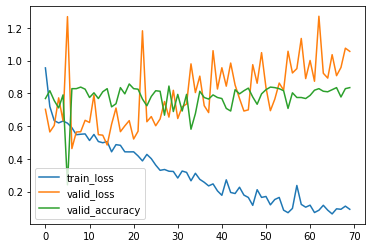

In [61]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [62]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.7654503936138866
TEST
loss: 0.5543534685694982
accuracy: 0.8063492063492064
******************
epoch: 1
Train
0.583930814616542
TEST
loss: 0.49053059059476095
accuracy: 0.8222222222222222
******************
epoch: 2
Train
0.47854084865359486
TEST
loss: 0.6050627816291082
accuracy: 0.7873015873015873
******************
epoch: 3
Train
0.46102477249122026
TEST
loss: 0.7513001619823395
accuracy: 0.834920634920635
******************
epoch: 4
Train
0.49541635282272567
TEST
loss: 1.544631706722199
accuracy: 0.4380952380952381
******************
epoch: 5
Train
0.46099659485699546
TEST
loss: 0.5095628754487114
accuracy: 0.8285714285714286
******************
epoch: 6
Train
0.4311078573333734
TEST
loss: 0.5052514453728993
accuracy: 0.8222222222222222
******************
epoch: 7
Train
0.31907378730080826
TEST
loss: 0.5045503059076885
accuracy: 0.8380952380952381
******************
epoch: 8
Train
0.32631421490402995
TEST
loss: 1.0866401958087133
accurac

In [63]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


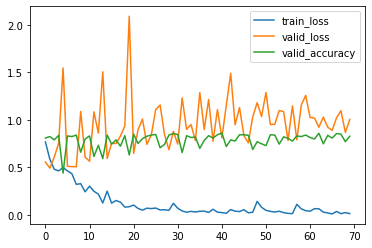

In [64]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [65]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.7723843876192549
TEST
loss: 0.6386696552473401
accuracy: 0.8126984126984127
******************
epoch: 1
Train
0.5855170419236987
TEST
loss: 0.5829887982398745
accuracy: 0.7746031746031746
******************
epoch: 2
Train
0.49387721569411236
TEST
loss: 0.7171600239617484
accuracy: 0.8063492063492064
******************
epoch: 3
Train
0.4793902038581036
TEST
loss: 0.6490853758085342
accuracy: 0.7936507936507936
******************
epoch: 4
Train
0.4947400394889265
TEST
loss: 0.6820008828526452
accuracy: 0.7904761904761904
******************
epoch: 5
Train
0.4178654242357249
TEST
loss: 0.7334202838322473
accuracy: 0.8095238095238095
******************
epoch: 6
Train
0.5000960374749588
TEST
loss: 1.8198060686626132
accuracy: 0.2984126984126984
******************
epoch: 7
Train
0.3783508888234971
TEST
loss: 0.6089015048647684
accuracy: 0.8412698412698413
******************
epoch: 8
Train
0.3465275132083249
TEST
loss: 0.5572322979805961
accuracy: 

In [66]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8096446700507615


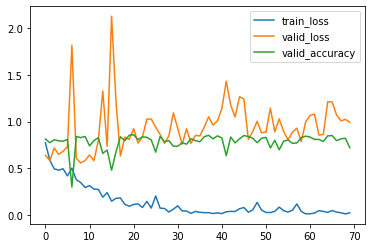

In [67]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [68]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8042115407202147
TEST
loss: 0.9903445107596262
accuracy: 0.7396825396825397
******************
epoch: 1
Train
0.5951670211302656
TEST
loss: 0.6008690981637864
accuracy: 0.8158730158730159
******************
epoch: 2
Train
0.4860020262367485
TEST
loss: 0.4760318319002787
accuracy: 0.8317460317460318
******************
epoch: 3
Train
0.43414541714431937
TEST
loss: 0.5086346531671191
accuracy: 0.8095238095238095
******************
epoch: 4
Train
0.4489087132445586
TEST
loss: 1.440880062088134
accuracy: 0.7619047619047619
******************
epoch: 5
Train
0.3930127699286148
TEST
loss: 0.6798442800839742
accuracy: 0.8031746031746032
******************
epoch: 6
Train
0.3134170524935764
TEST
loss: 0.9021713945600721
accuracy: 0.6793650793650794
******************
epoch: 7
Train
0.25451035235399666
TEST
loss: 1.1328027483016725
accuracy: 0.7841269841269841
******************
epoch: 8
Train
0.3320899457331211
TEST
loss: 0.9200787877279615
accuracy: 

In [69]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8324873096446701


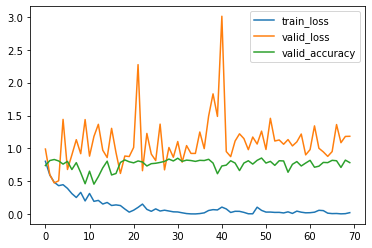

In [70]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [71]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.7753436526341321
TEST
loss: 0.5720205537856571
accuracy: 0.8031746031746032
******************
epoch: 1
Train
0.5602787295156665
TEST
loss: 0.5388754326199728
accuracy: 0.8444444444444444
******************
epoch: 2
Train
0.4880160791614493
TEST
loss: 0.5479104908685836
accuracy: 0.834920634920635
******************
epoch: 3
Train
0.42950027175040545
TEST
loss: 1.772218792779105
accuracy: 0.5206349206349207
******************
epoch: 4
Train
0.42494872347337087
TEST
loss: 0.5830020280111403
accuracy: 0.8222222222222222
******************
epoch: 5
Train
0.3707130665907886
TEST
loss: 0.69925241829857
accuracy: 0.8031746031746032
******************
epoch: 6
Train
0.3297862800887125
TEST
loss: 0.6326701979788523
accuracy: 0.8412698412698413
******************
epoch: 7
Train
0.2706432096464848
TEST
loss: 0.7055456600491963
accuracy: 0.8158730158730159
******************
epoch: 8
Train
0.2874710332776839
TEST
loss: 0.5215454095885868
accuracy: 0.8

In [72]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.7918781725888325


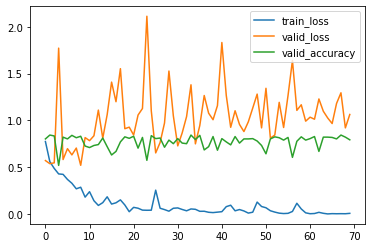

In [73]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [74]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8058867569335213
TEST
loss: 0.5665715711457389
accuracy: 0.8031746031746032
******************
epoch: 1
Train
0.6289204551739954
TEST
loss: 1.3237959910952857
accuracy: 0.7777777777777778
******************
epoch: 2
Train
0.5590026419583155
TEST
loss: 0.6161623127876766
accuracy: 0.7968253968253968
******************
epoch: 3
Train
0.46890139487454396
TEST
loss: 1.6647364745064388
accuracy: 0.726984126984127
******************
epoch: 4
Train
0.49868210551282355
TEST
loss: 1.0864918810980662
accuracy: 0.7746031746031746
******************
epoch: 5
Train
0.46009699132728427
TEST
loss: 0.5897937541916257
accuracy: 0.834920634920635
******************
epoch: 6
Train
0.4087177503904338
TEST
loss: 0.5320937300485278
accuracy: 0.7904761904761904
******************
epoch: 7
Train
0.3656427241015567
TEST
loss: 0.6192313964404758
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.34785425111450213
TEST
loss: 0.7585689062163943
accuracy:

In [75]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8375634517766497


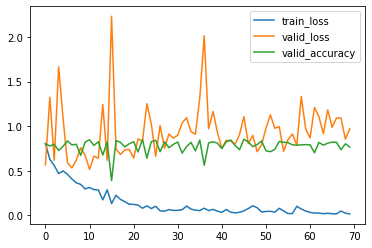

In [76]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [77]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8651807204042757
TEST
loss: 3.8753948158688014
accuracy: 0.473015873015873
******************
epoch: 1
Train
0.6235513219859886
TEST
loss: 0.5369321145708599
accuracy: 0.8317460317460318
******************
epoch: 2
Train
0.5584602248488768
TEST
loss: 0.4848021603765942
accuracy: 0.8253968253968254
******************
epoch: 3
Train
0.5058298051309926
TEST
loss: 0.5148944816892109
accuracy: 0.834920634920635
******************
epoch: 4
Train
0.5330004229301304
TEST
loss: 0.48610941890686277
accuracy: 0.8444444444444444
******************
epoch: 5
Train
0.48615043581336903
TEST
loss: 0.5852850015201266
accuracy: 0.765079365079365
******************
epoch: 6
Train
0.44305830445906963
TEST
loss: 0.7326559534148565
accuracy: 0.7142857142857143
******************
epoch: 7
Train
0.37620141551880915
TEST
loss: 0.5728313555793156
accuracy: 0.8063492063492064
******************
epoch: 8
Train
0.39306612520510475
TEST
loss: 0.5679021646106054
accuracy:

In [78]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8121827411167513


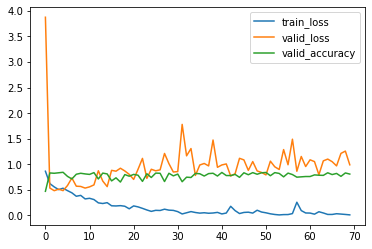

In [79]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()